# Programming Assignment 4
## Neural Networks

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Matrícula: 518659


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions

## Metrics

In [3]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

    right_prediction = y_true == y_pred
    accuracy = right_prediction.sum() / len(y_true)
    return accuracy

def recall(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,0] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    recall = right_prediction.sum() / len(array)
    return recall

def precision(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,1] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    precision = right_prediction.sum() / len(array)

    return precision

def f1_score(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    precision_score = precision(y_true, y_pred)
    recall_score = recall(y_true, y_pred)

    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return f1_score

def get_mse(y_real, y_pred):
    return np.mean((y_real - y_pred)**2)

def get_rmse(y_real, y_pred):
    return np.sqrt(get_mse(y_real, y_pred))

## MinMaxScaler

In [4]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

## Standardization


In [5]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Cross Validation

In [6]:
def get_cv_folds(data, n_folds=10, shuffle=True, random_state=12894):
    indexes = np.arange(data.shape[0])
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(indexes)

    slices = np.array_split(indexes, n_folds)
    all_elements = np.hstack(slices)   
    
    splits = []
    for i in range(n_folds):
        train_idx = all_elements[~np.isin(all_elements, slices[i])]
        test_idx = slices[i]

        splits.append((train_idx, test_idx))

    return splits

## Train Test Split

In [7]:
def train_test_split(X, y, train_size_perc, random_seed=264852):
    
    y = y.reshape(-1, 1)
    
    N = X.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    X_train = X[train_idx, :]
    y_train = y[train_idx, :]
    X_test = X[test_idx, :]
    y_test = y[test_idx, :]

    return X_train, X_test, y_train, y_test


## Do Cross Validation and Get Metrics

In [8]:
def do_cv_and_get_metrics(classifier, cv_splits, X_train, y_train, X_test, title='Classifier', scaler=None):

    X_train = X_train.copy()
    y_train = y_train.copy()
    X_test = X_test.copy()

    train_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }

    valid_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }
    # Reporting results
    print('#' + f'{title}'.center(60, '-') + '#')

    print('\n---> Validation Folds Metrics')
    print('Fold\tAccuracy\tRecall\t\tPrecision\tF1-Score')
    count_fold = 1
    for train_idx, val_idx in cv_splits:
        # Spliting data
        X_train_cv = X_train[train_idx, :]
        y_train_cv = y_train[train_idx, :]
        X_val_cv = X_train[val_idx, :]
        y_val_cv = y_train[val_idx, :]

        # Scaling if have scaler argument
        if scaler is not None:
            X_train_cv = scaler.fit_transform(X_train_cv)
            X_val_cv = scaler.transform(X_val_cv)

        # Training Model
        classifier.fit(X_train_cv, y_train_cv.ravel())

        # Predictions
        y_train_cv_pred = classifier.predict(X_train_cv)
        y_val_cv_pred = classifier.predict(X_val_cv)

        # Storing metrics
        train_metrics['accuracy'].append(accuracy(y_train_cv, y_train_cv_pred))
        train_metrics['recall'].append(recall(y_train_cv, y_train_cv_pred))
        train_metrics['precision'].append(precision(y_train_cv, y_train_cv_pred))
        train_metrics['f1_score'].append(f1_score(y_train_cv, y_train_cv_pred))

        valid_metrics['accuracy'].append(accuracy(y_val_cv, y_val_cv_pred))
        valid_metrics['recall'].append(recall(y_val_cv, y_val_cv_pred))
        valid_metrics['precision'].append(precision(y_val_cv, y_val_cv_pred))
        valid_metrics['f1_score'].append(f1_score(y_val_cv, y_val_cv_pred))

        print('{0:.0f}\t{1:.4f}  \t{2:.4f}\t\t{3:.4f}   \t{4:.4f}'.format(
                count_fold,
                valid_metrics['accuracy'][-1], 
                valid_metrics['recall'][-1],
                valid_metrics['precision'][-1],
                valid_metrics['f1_score'][-1]
            )
        )
        count_fold+=1


    print('\n--->\tTraining Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['accuracy']), 
        np.std(train_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(train_metrics['recall']), 
        np.std(train_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['precision']), 
        np.std(train_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['f1_score']), 
        np.std(train_metrics['f1_score']))
    )

    print('\n--->\tValidation Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['accuracy']), 
        np.std(valid_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(valid_metrics['recall']), 
        np.std(valid_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['precision']), 
        np.std(valid_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['f1_score']), 
        np.std(valid_metrics['f1_score']))
    )

    print('\n--->\tTest Metrics')

    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.ravel())
    y_test_pred = classifier.predict(X_test)

    print('Accuracy:     \t{0:.4f}'.format(accuracy(y_test, y_test_pred)))
    print('Recall:     \t{0:.4f}'.format(recall(y_test, y_test_pred)))
    print('Precision:     \t{0:.4f}'.format(precision(y_test, y_test_pred)))
    print('F1 Score:     \t{0:.4f}'.format(f1_score(y_test, y_test_pred)))


# Task 1 - MLP (Regression)

In [9]:
data = np.genfromtxt('../data/concrete.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
print('Shape:', data.shape)
data[:3, :]


Shape: (1030, 9)


array([[ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1040.  ,  676.  ,
          28.  ,   79.99],
       [ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1055.  ,  676.  ,
          28.  ,   61.89],
       [ 332.5 ,  142.5 ,    0.  ,  228.  ,    0.  ,  932.  ,  594.  ,
         270.  ,   40.27]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 0.8, random_seed=466852
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 0.75, random_seed=654824
)

print('Number of Rows by Split')
print('X_train: {} ({}%)'.format(X_train.shape[0], X_train.shape[0]/data.shape[0]*100))
print('X_test:  {} ({}%)'.format(X_test.shape[0], X_test.shape[0]/data.shape[0]*100))
print('X_val:   {} ({}%)'.format(X_val.shape[0], X_val.shape[0]/data.shape[0]*100))

Number of Rows by Split
X_train: 618 (60.0%)
X_test:  206 (20.0%)
X_val:   206 (20.0%)


In [393]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)

In [394]:
class Sigmoid():
    @staticmethod
    def get_value(x):
        return 1/(1+np.exp(-x))

    @staticmethod
    def get_derivative(x):
        return Sigmoid.get_value(x) - Sigmoid.get_value(x)**2

class ReLU():
    @staticmethod
    def get_value(x):
        return np.maximum(0, x)

    @staticmethod
    def get_derivative(x):
        return np.where(x <= 0, 0, 1)

class Identity():
    @staticmethod
    def get_value(x):
        return np.ones(x.shape) * x

    @staticmethod
    def get_derivative(x):
        return np.ones(x.shape)

### Important Shapes
$$
H_i(hidden\_weight) \rArr (n\_neurons(H_{i-1}), n\_neurons(H_i))

$$

In [368]:
# FUNCIONANDO PARA 1 EXEMPLO
class MyMLP():
    def __init__(self, n_inputs, n_outputs):
        self.fitted = False
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.n_hidden = []
        self.weights = []
        self.activation_functions = [Identity(), Sigmoid()]
        self.layer_inputs = []
        self.layer_outputs = []
        self.hidden_activation_derivatives = []
        self.deltas = []

    def get_n_neurons_of_last_layer(self):
        if len(self.weights) == 0:
            return self.n_inputs
        else:
            return len(self.weights[-1])

    def add_hidden_layer(self, n_neurons, activation_function):
        self.n_hidden.append(n_neurons)
        self.activation_functions = self.activation_functions[:-1] \
            + [activation_function] \
            + [self.activation_functions[-1]]

    def initialize_weights(self, random_state=8776123):
        self.weights = []

        seed = np.random.RandomState(random_state)
        self.layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]
        
        for i in range(len(self.layers)-1):
            # Initialization strategies
            if type(self.activation_functions[i]) == ReLU:
                w = seed.normal(
                    size = (self.layers[i]+1, self.layers[i+1])
                ) * np.sqrt(2/self.layers[i])  
                w[0, :] = 0.01
            else:
                w = seed.normal(
                    size = (self.layers[i]+1, self.layers[i+1])
                ) * np.sqrt(1/self.layers[i])
                w[0, :] = 0


            # self.weights.append(w)
        self.weights.append(np.array([
            [0, 0], 
            [0.1, 0.4],
            [0.8, 0.6]
        ]))
        self.weights.append(np.array([
            [0], 
            [0.3],
            [0.9]
        ]))



    def forward_propagation(self, X):
        activated_values = X

        self.layer_outputs = []
        self.hidden_activation_derivatives = []

        self.layer_outputs.append(activated_values)

        for i, w in enumerate(self.weights):
            # Insert first column with ones to multiply bias term
            activated_values = np.hstack([np.ones((activated_values.shape[0], 1)), activated_values])
            
            activation_function = self.activation_functions[i+1]            
            
            # Calculating input of hidden layer
            hidden_input = np.array(activated_values @ w)
            if activation_function is not None:
                # print('FORWARD', i)
                # print(hidden_input)
                # print(activation_function.get_value(hidden_input))
                # print(activation_function)
                activated_values = activation_function.get_value(hidden_input)
            else:
                activated_values = hidden_input
                
            self.layer_inputs.append(hidden_input)
            self.layer_outputs.append(activated_values)
        
        self.layer_inputs = [X] + self.layer_inputs
        return activated_values # Output


    def back_propagation(self, error, alpha=1):

        # calcular os deltas
        last_layers = True
        for i in range(len(self.activation_functions)-1, 0, -1):

            act_function = self.activation_functions[i]
            layer_inputs = self.layer_inputs[i]

            if last_layers:
                calc_i = error * act_function.get_derivative(layer_inputs)
                self.deltas = [calc_i] + self.deltas
                # print(self.deltas)
                last_layers=False
            else:
                weights = self.weights[i][1:]
                
                # print('weights')
                # print(weights.shape)
                # print(weights)
                # print('delta')
                # print(self.deltas[0].shape)
                # print(self.deltas[0])
                # print('act_function')
                # print(act_function.get_derivative(layer_inputs).T.shape)
                # print(act_function.get_derivative(layer_inputs).T)
                
                calc_i = weights @ self.deltas[0] * act_function.get_derivative(layer_inputs).T
                self.deltas = [calc_i] + self.deltas
                # calc_i = error * act_function.get_derivative(layer_inputs)

        # print('\n\n\n----------PESOS\n\n\n')
        print('\nPesos Antes')
        print(self.weights)
        for i in range(len(self.weights)):
            # print('\n\n', i, '\n\n')
            
            # print(self.deltas[i])
            # print(self.layer_outputs[i])
            # print(self.deltas[i] @ self.layer_outputs[i])
            # print('\nTESTE\n')
            # print(self.weights[i][1:])
            # print(gradient.T)
            gradient = self.deltas[i] @ self.layer_outputs[i]
            self.weights[i][1:, :] = self.weights[i][1:, :] - alpha * gradient.T

            # print(i)  
            # print(self.layer_inputs[i])
        print('\nPesos DEPOIS')
        print(self.weights)


            
    def fit(self, X, y):
        pass

    def predict(self, X):
        pass

my_mlp = MyMLP(n_inputs=2, n_outputs=2)
my_mlp.add_hidden_layer(n_neurons=2, activation_function=Sigmoid())
# my_mlp.add_hidden_layer(n_neurons=2, activation_function=ReLU())

my_mlp.initialize_weights()

X = np.array([[0.35, 0.9]])
y = np.array([[0.5]])

y_pred = my_mlp.forward_propagation(X)
error = y_pred - y

my_mlp.back_propagation(error)


Pesos Antes
[array([[0. , 0. ],
       [0.1, 0.4],
       [0.8, 0.6]]), array([[0. ],
       [0.3],
       [0.9]])]

Pesos DEPOIS
[array([[0.        , 0.        ],
       [0.09907093, 0.39713992],
       [0.79761096, 0.59264552]]), array([[0.        ],
       [0.27232597],
       [0.87299836]])]


MSE Epoch 0: 0.04805965977105774
MSE Epoch 1: 0.039076521861883734
MSE Epoch 2: 0.03447773109851601
MSE Epoch 3: 0.03113414148230009
MSE Epoch 4: 0.02796634479332156
MSE Epoch 5: 0.024472091823557005
MSE Epoch 6: 0.02181923695054833
MSE Epoch 7: 0.020516002779436278
MSE Epoch 8: 0.019837233405229016
MSE Epoch 9: 0.0193823749327655
MSE Epoch 10: 0.01905162777127944
MSE Epoch 11: 0.018775507509445587
MSE Epoch 12: 0.01851138010872693
MSE Epoch 13: 0.018198149985739414
MSE Epoch 14: 0.01790077179872681
MSE Epoch 15: 0.01760338274502916
MSE Epoch 16: 0.017350367823752048
MSE Epoch 17: 0.01709170961266884
MSE Epoch 18: 0.016864421319616518
MSE Epoch 19: 0.01663760389634482
MSE Epoch 20: 0.016411802724190756
MSE Epoch 21: 0.016182675908530383
MSE Epoch 22: 0.015983542871350797
MSE Epoch 23: 0.015815470169183582
MSE Epoch 24: 0.015658281410907485
MSE Epoch 25: 0.015518215638466162
MSE Epoch 26: 0.015383341481868318
MSE Epoch 27: 0.015263298986924632
MSE Epoch 28: 0.015136112933112398
MSE Epoc

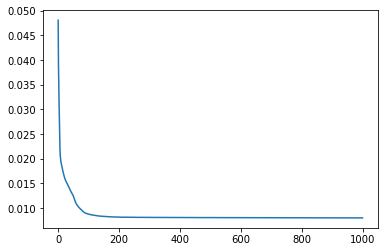

In [750]:
class MyMLP():
    def __init__(self, n_inputs, n_outputs, verbose=False):
        self.fitted = False
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.verbose=verbose
        self.n_hidden = []
        self.weights = []
        self.activation_functions = [Identity(), Sigmoid()]
        self.layer_inputs = []
        self.layer_outputs = []
        self.deltas = []

    def get_n_neurons_of_last_layer(self):
        if len(self.weights) == 0:
            return self.n_inputs
        else:
            return len(self.weights[-1])

    def add_hidden_layer(self, n_neurons, activation_function):
        self.n_hidden.append(n_neurons)
        self.activation_functions = self.activation_functions[:-1] \
            + [activation_function] \
            + [self.activation_functions[-1]]

    def initialize_weights(self, random_state=8776123):
        self.weights = []

        seed = np.random.RandomState(random_state)
        self.layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]
        
        for i in range(len(self.layers)-1):
            # Initialization strategies
            if type(self.activation_functions[i]) == ReLU:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(2/self.layers[i])  
                # w = np.random.rand(self.layers[i+1], self.layers[i])
            else:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(1/self.layers[i])
                # w = np.random.rand(self.layers[i+1], self.layers[i])
            self.weights.append(w)

    def forward_propagation(self, X):
        activated_values = X

        self.layer_inputs = []
        self.layer_outputs = []

        self.layer_outputs.append(activated_values)

        for i, w in enumerate(self.weights):
            # Insert first column with ones to multiply bias term
            activation_function = self.activation_functions[i+1]            
            
            # Calculating input of hidden layer
            hidden_input = np.array(activated_values @ w.T)
            if activation_function is not None:
                activated_values = activation_function.get_value(hidden_input)
            else:
                activated_values = hidden_input
                
            self.layer_inputs.append(hidden_input)
            self.layer_outputs.append(activated_values)
        
        self.layer_inputs = [X] + self.layer_inputs
        return activated_values # Output


    def back_propagation(self, error, alpha=0.1):
        # calcular os deltas
        last_layers = True
        self.deltas = []
        for i in range(len(self.activation_functions)-1, 0, -1):
            act_function = self.activation_functions[i]
            layer_inputs = self.layer_inputs[i]
            if last_layers:
                delta_i = error * act_function.get_derivative(layer_inputs)
                self.deltas = [delta_i] + self.deltas
                last_layers=False
            else:
                weights = self.weights[i]
                
                if self.verbose == True:
                    print(f'------ ITERAÇÃO {i} ------')
                    print('\nweights')
                    print(weights.shape)
                    print(weights)
                    print('\ndelta')
                    print(self.deltas[0].shape)
                    print(self.deltas[0])
                    print('\nact_function')
                    print(act_function.get_derivative(layer_inputs).shape)
                    print(act_function.get_derivative(layer_inputs))

                delta_i = act_function.get_derivative(layer_inputs) \
                    * (self.deltas[0] @ weights)
                self.deltas = [delta_i] + self.deltas

        for i in range(len(self.weights)):
            gradient = self.deltas[i].T @ self.layer_outputs[i]
            self.weights[i] = self.weights[i] - alpha * gradient
            
    def fit(self, X, y):
        pass

    def predict(self, X):
        activated_values = X

        for i, w in enumerate(self.weights):
            activation_function = self.activation_functions[i+1]           
            
            # Calculating input of hidden layer
            hidden_input = np.array(activated_values @ w.T)
            activated_values = activation_function.get_value(hidden_input)

        
        self.layer_inputs = [X] + self.layer_inputs
        return activated_values

my_mlp = MyMLP(n_inputs=8, n_outputs=1, verbose=False)
my_mlp.add_hidden_layer(n_neurons=4, activation_function=ReLU())
# my_mlp.add_hidden_layer(n_neurons=2, activation_function=ReLU())

my_mlp.initialize_weights(65421)

cost_function_curve = []

epochs = 1000
for i in range(epochs):
    mse = 0
    count = 0
    for input, output in zip(X_train_scaled, y_train_scaled):
        input_reshaped = input.reshape(1, -1)
        output_reshaped = output.reshape(1, -1)        
        y_pred = my_mlp.forward_propagation(input_reshaped)
        error = y_pred - output_reshaped
        my_mlp.back_propagation(error, 0.1)

        mse+=get_mse(output, y_pred)
        count+=1

    cost_function_curve.append(mse/count)
    print(f'MSE Epoch {i}:', mse/count)

# for i in range(epochs):
 
#     y_pred = my_mlp.forward_propagation(X_train_scaled)
#     error = y_pred - y_train_scaled
#     my_mlp.back_propagation(error, 0.1)

#     mse=get_mse(y_train_scaled, y_pred)

#     cost_function_curve.append(mse)
#     print(f'MSE Epoch {i}:', mse)


plt.plot(cost_function_curve)


In [747]:
y_test_pred = my_mlp.predict(X_test_scaled)

mse = get_mse(
    y_test_scaled,
    y_test_pred
)
mse


0.01158037522566841

## Teste Keras

In [717]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
import keras
import tensorflow as tf

In [751]:
model = Sequential()

model.add(Dense(8))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0))

model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=1)

Epoch 1/100
618/618 [==============================] - 1s 760us/step - loss: 0.0605
Epoch 2/100
618/618 [==============================] - 0s 760us/step - loss: 0.0566
Epoch 3/100
618/618 [==============================] - 1s 835us/step - loss: 0.0573
Epoch 4/100
618/618 [==============================] - 0s 793us/step - loss: 0.0540
Epoch 5/100
618/618 [==============================] - 1s 891us/step - loss: 0.0569
Epoch 6/100
618/618 [==============================] - 0s 733us/step - loss: 0.0559
Epoch 7/100
618/618 [==============================] - 0s 764us/step - loss: 0.0563
Epoch 8/100
618/618 [==============================] - 0s 759us/step - loss: 0.0566
Epoch 9/100
618/618 [==============================] - 0s 768us/step - loss: 0.0576
Epoch 10/100
618/618 [==============================] - 0s 762us/step - loss: 0.0559
Epoch 11/100
618/618 [==============================] - 0s 768us/step - loss: 0.0563
Epoch 12/100
618/618 [==============================] - 0s 754us/step - lo

In [752]:
y_test_pred = model.predict(X_test_scaled)

mse = get_mse(
    y_test_scaled,
    y_test_pred
)
mse

7/7 [==============================] - 0s 833us/step


0.06007824461022472

In [429]:
my_mlp.deltas

[]

In [203]:
my_mlp.layer_outputs[0]

array([[0.35, 0.9 ],
       [0.35, 0.9 ]])

In [104]:
my_mlp.deltas

[array([[0.00265449],
        [0.00817165]]),
 array([[0.04068113]])]

In [81]:
my_mlp.layer_outputs

[array([[0.35, 0.9 ]]), array([[0.755, 0.68 ]]), array([[0.6981492]])]

In [82]:
my_mlp.layer_inputs

[array([[0.35, 0.9 ]]), array([[0.755, 0.68 ]]), array([[0.8385]])]

In [17]:
my_mlp.hidden_activation_values

[array([[0.35, 0.9 ]]), array([[0.6802672, 0.6637387]]), array([[0.69028349]])]

In [1002]:
my_mlp.layer_values

[array([[0.35, 0.9 ]]), array([[0.755, 0.68 ]]), array([[0.80144499]])]

In [1003]:
my_mlp.hidden_activation_values

[array([[0.35, 0.9 ]]), array([[0.6802672, 0.6637387]]), array([[0.69028349]])]

In [961]:
my_mlp.hidden_weights

[array([[ 0.01      ,  0.01      ],
        [-1.30874051, -1.02080529],
        [-0.73480594,  1.48559353]]),
 array([[ 0.        ],
        [-0.96229814],
        [-0.25849241]])]

In [922]:
my_mlp.layer_values

[array([[1, 1]]), array([[-2.03354645,  0.47478824]]), array([[-0.12272916]])]

In [920]:
my_mlp.hidden_activation_values

[array([[1, 1]]), array([[0.        , 0.47478824]]), array([[-0.12272916]])]

[array([[-4.0770929 ,  0.93957648]]), array([[-0.24287339]])]

In [834]:
my_mlp.hidden_activation_values

[array([[2, 2]]),
 array([[0.        , 0.        , 2.25006011]]),
 array([[1.72497389]])]

In [829]:
my_mlp.hidden_activation_derivatives

[array([[-0.55005223],
        [-0.55005223]]),
 array([[ 0.        ],
        [ 0.        ],
        [-0.61882529]])]

In [779]:
for i in range(2):
    print(i)

0
1


In [743]:
my_mlp.initialize_weights()
my_mlp.hidden_weights

[array([[ 0.01      ,  0.01      ,  0.01      ],
        [-1.02080529, -0.73480594,  1.48559353],
        [-0.52143647, -1.36089508, -0.36556347]]),
 array([[ 0.01      ,  0.01      ],
        [-1.25788996,  1.08418502],
        [ 0.75540738,  0.68650945],
        [ 0.60064027,  0.32373336]]),
 array([[ 0.        ],
        [-1.01657088],
        [-1.08121814]])]

In [752]:
my_mlp.hidden_activation_values

[array([[2, 2]]),
 array([[0.        , 0.        , 2.25006011]]),
 array([[1.36147672, 0.73841953]]),
 array([[-2.18243018]])]